<a href="https://colab.research.google.com/github/quang-pham/DeeplearningTutorial/blob/main/CNN_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Main
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Learning
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

import os

In [ ]:

# 「縦×横×チャネル数」(torchvision)から「チャネル数×縦×横」(Pytorch)に変換
transform_torchvision = transforms.Compose([
  transforms.ToTensor(), #変換方法
  transforms.Normalize(
      [0.5, 0.5, 0.5], #RGBの平均
      [0.5, 0.5, 0.5] #RGBの標準偏差
  )
])

# CIFAR10データセットを読み込み
# 学習データ
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', #データ保存場所
    train=True, # 学習データ
    download=True, #ダウンロード
    transform=transform_torchvision
)

# テストデータ
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform_torchvision
)

# ダウンロードしデータの確認
image, label = train_dataset[0]
print(f"画像サイズ: {image.size()},\nラベルサイズ: {label}")

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz



Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
画像サイズ: torch.Size([3, 32, 32]),
ラベルサイズ: 6


In [ ]:
# ミニバッチを作成(いくつかまとめて学習させるやつ)
# 学習バッチ
train_batch = DataLoader(dataset=train_dataset,
                         batch_size=64,
                         shuffle=True,
                         num_workers=2) # 並列実行数 8までは高速化できる

# テストバッチ
test_batch = DataLoader(dataset=test_dataset,
                         batch_size=64,
                         shuffle=False,
                         num_workers=2) # 並列実行数 8までは高速化できる  


# ミニバッチデータセットの確認
for images,  labels in train_batch:
  print(f"バッチの画像サイズ: {images.size()}")
  print(f"1枚の画像サイズ: {images[0].size()}")
  print(f"バッチのラベルサイズ: {labels.size()}")
  break

バッチの画像サイズ: torch.Size([64, 3, 32, 32])
1枚の画像サイズ: torch.Size([3, 32, 32])
バッチのラベルサイズ: torch.Size([64])


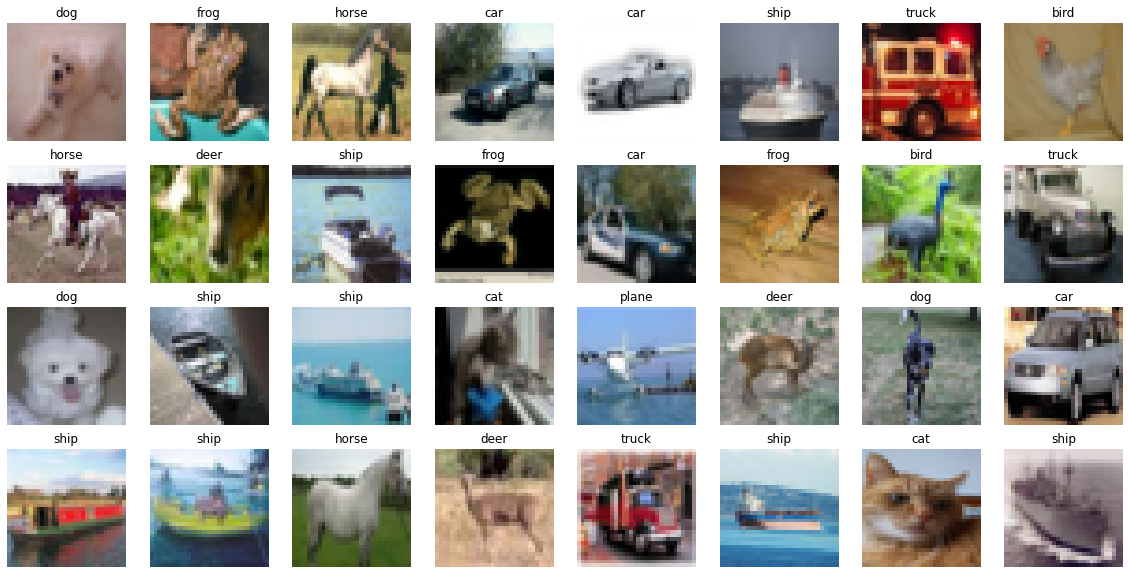

In [ ]:
# CIFAR-10の表示
classess = ["plane", "car", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"]

for images, labels in train_batch:
  plt.figure(figsize=(20, 10))
  for i in range(32):
    image = images[i] / 2 + 0.5 # 標準化を解除
    image = image.numpy() # Tensorからndarrayへ
    # plt.figure(figsize=(10, 10))
    plt.subplot(4, 8, i+1)
    plt.imshow(np.transpose(image, (1, 2, 0))) # matplotlibでは「縦×横×チャネル数」だから変換
    plt.title(classess[labels[i]])
    plt.axis("off")
  plt.show()
  break

In [ ]:
# ニューラルネットワークの定義 (AlexNet)
num_classess = 10

class AlexNet(nn.Module):
  def __init__(self, num_classess=num_classess):
    super(AlexNet, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, padding=2), #畳み込み層
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 3 * 3, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classess)
    )
    

  # def forward(self, x):
  #   x = self.features(x) # 特徴量抽出
  #   x = x.view(x.size(0), 256*3*3) #全結合
  #   x = self.classifier(x) # 画像分類
  #   return x
  def forward(self, x):
    x = self.features(x)  # 画像特徴量抽出パート
    x = x.view(x.size(0), 256 * 3 * 3)  # 3次元から1次元に変えて全結合層へ
    x = self.classifier(x)  # 画像分類パート
    return x


# AlexNetの利用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = AlexNet().to(device)
print("ネットワーク構造")
print(net)
print(f"デバイス: {device}")

ネットワーク構造
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(

In [ ]:
# 回帰 => 平均二乗誤差(MSE), 平均絶対誤差(MEA)
# 2値判別 => 交差エントロピー誤差(バイナリ)
# 他クラス分類 => 交差エントロピー誤差(カテゴリ)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())
# 学習率を自動的に制御してくれるAdamを利用

In [ ]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for images, labels in train_batch:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(images)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch)
    epoch_train_accuracy = train_accuracy / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for images, labels in test_batch:
            # GPUにTensorを転送
            images = images.to(device)
            labels = labels.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(images)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.max(y_pred_prob, 1)[1]
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch)
    epoch_test_accuracy = test_accuracy / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)
    train_accuracy_list.append(epoch_train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_accuracy_list.append(epoch_test_accuracy)

---------------------------------------------
Epoch: 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train_Loss: 1.7772, Train_Accuracy: 0.3130
Test_Loss: 1.5085, Test_Accuracy: 0.4176
---------------------------------------------
Epoch: 2/10
Train_Loss: 1.4378, Train_Accuracy: 0.4760
Test_Loss: 1.2797, Test_Accuracy: 0.5343
---------------------------------------------
Epoch: 3/10
Train_Loss: 1.2863, Train_Accuracy: 0.5376
Test_Loss: 1.2088, Test_Accuracy: 0.5728
---------------------------------------------
Epoch: 4/10
Train_Loss: 1.1803, Train_Accuracy: 0.5783
Test_Loss: 1.1401, Test_Accuracy: 0.6001
---------------------------------------------
Epoch: 5/10
Train_Loss: 1.0996, Train_Accuracy: 0.6100
Test_Loss: 1.1079, Test_Accuracy: 0.6147
---------------------------------------------
Epoch: 6/10
Train_Loss: 1.0350, Train_Accuracy: 0.6356
Test_Loss: 1.0244, Test_Accuracy: 0.6458
---------------------------------------------
Epoch: 7/10
Train_Loss: 0.9761, Train_Accuracy: 0.6576
Test_Loss: 1.0158, Test_Accuracy: 0.6458
---------------------------------------------
Epoch: 8/10
Train_

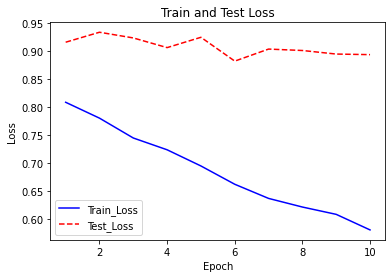

In [ ]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット

plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 表示
plt.show()

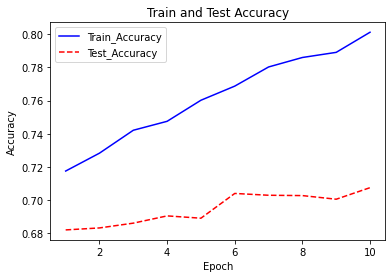

In [ ]:
# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

plt.show()

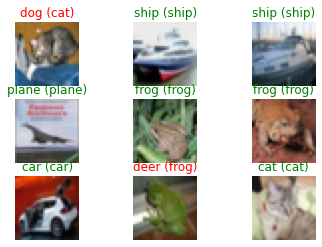

In [ ]:
# 分類した画像を確認
# CIFAR10のクラス
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    for images, labels in test_batch:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(images)
        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]

        for i in range(9):  # 9枚の画像を表示
            image = images[i] / 2 + 0.5  # 標準化を解除
            image = image.to('cpu').numpy()  # CPUにTensorを渡してからndarrayへ変換
            plt.subplot(3, 3, i+1)  # 5x8となるようにプロット
            # matplotlibでは(縦, 横, チャネル)の順
            plt.imshow(np.transpose(image, (1, 2, 0)))
            plt.title(classes[labels[i]])  # ラベルをタイトルに
            plt.title("{} ({})".format(classes[y_pred_labels[i].item()],
                                       classes[labels[i].item()]),
                      color=('green' if y_pred_labels[i] == labels[i] else 'red'))  # ラベルをタイトルに
            plt.axis('off')  # 目盛を消去
        plt.show()  # 表示
        break